# Health Study Python INL1 - Martin Westberg

In [19]:
# För att få relative path utifrån notebookens workspace mapp.
import sys, os 
sys.path.append(os.path.abspath(".."))

In [20]:
# Läs in datan och visa upp sista 2 raderna (data health check)
import pandas as pd
df = pd.read_csv("./data/health_study_dataset.csv")
df.tail(2)

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
798,799,50,F,172.6,55.3,155.0,3.58,No,0
799,800,50,M,189.2,79.4,139.7,5.62,No,0


In [21]:
df.info() # inga NaN. Length är 800 rader.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           800 non-null    int64  
 1   age          800 non-null    int64  
 2   sex          800 non-null    object 
 3   height       800 non-null    float64
 4   weight       800 non-null    float64
 5   systolic_bp  800 non-null    float64
 6   cholesterol  800 non-null    float64
 7   smoker       800 non-null    object 
 8   disease      800 non-null    int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 56.4+ KB


## 1. Beskrivande analys

Vi ska räkna ut medel, median, min & max för: age, weight, height, systolic_bp, cholestrol.

Det blir lättast visualiserat med en Pandas DataFrame:

In [22]:
import numpy as np
age  = df['age']
weig = df['weight']
heig = df['height']
syst = df['systolic_bp']
chol = df['cholesterol']

summary = pd.DataFrame({
    "Age": [age.mean(), age.median(), age.min(), age.max()],
    "Weight": [weig.mean(), weig.median(), weig.min(), weig.max()],
    "Height": [heig.mean(), heig.median(), heig.min(), heig.max()],
    "Blood Pressure": [syst.mean(), syst.median(), syst.min(), syst.max()],
    "Cholesterol": [chol.mean(), chol.median(), chol.min(), chol.max()]
}, index=["Mean","Median","Min", "Max"])

display(summary.round(1))

,Age,Weight,Height,Blood Pressure,Cholesterol
Mean,49.4,73.4,171.8,149.2,4.9
Median,50.0,73.2,171.4,149.4,5.0
Min,18.0,33.7,144.4,106.8,2.5
Max,90.0,114.4,200.4,185.9,7.9


---

Vi ska skapa 3 olika grafer.

Det blir ett histogram av blodtrycksvärden, för att se hur många som hamnar i inkrementerade intervall.

Det blir även en boxplot som ska visa hur män och kvinnor väger, då medelvärden, medianer, kvadranter och outliers presenteras.

Det blir slutligen en bar graf av hur många som röker, vilket ger en enkel kategorisk jämförelse.

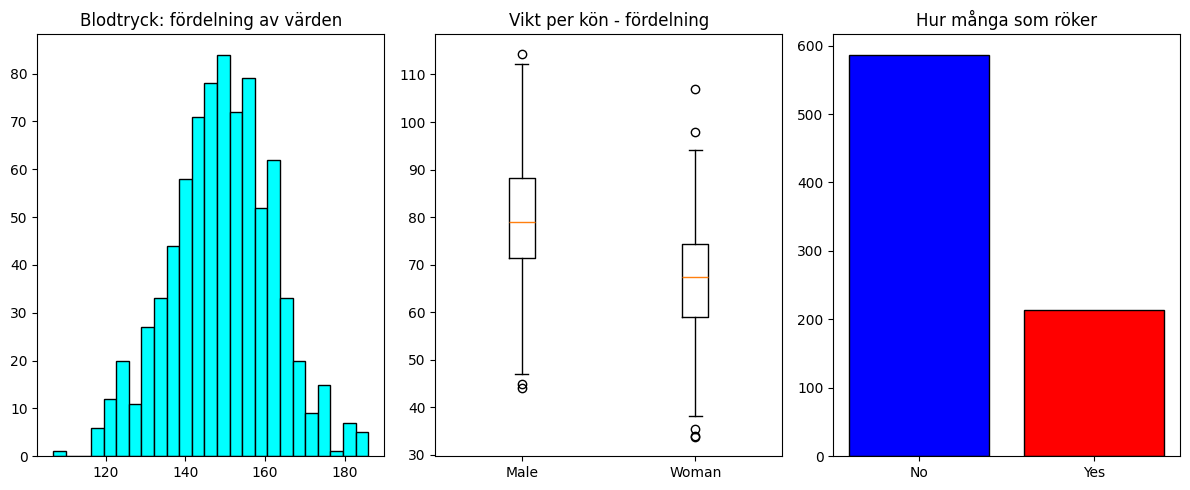

In [5]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,3, figsize=(12,5)) # 3 plots i samma figur

# Plot längst till vänster 
# (histogram över blodtryck)
ax[0].hist(df["systolic_bp"], bins=25, edgecolor="black",color="cyan")
ax[0].set_title("Blodtryck: fördelning av värden")

# Plot i mitten 
# (boxplot, vikt per kön)
gender_weights = [df[df['sex']=="M"]['weight'], df[df['sex']=="F"]['weight']] # lista med män's vikt och kvinnor's vikt
ax[1].boxplot(gender_weights, tick_labels=['Male','Woman'])
ax[1].set_title("Vikt per kön - fördelning")

# Plot till höger 
# (stapeldiagram: andelen rökare)
quantity_smokers = df['smoker'].value_counts() # räknar hur många "Yes" och "No" i kolumnen 'smoker'
ax[2].bar(quantity_smokers.index, quantity_smokers.values, edgecolor="black", color=["blue","red"])
ax[2].set_title("Hur många som röker")

plt.tight_layout()
plt.show()

Kommentar:
- Till vänster ser vi ett till synes normalt fördelat histogram, där väldigt få har lägre än 120 och få har högre än 180, och flest har runt 150 i blodtryck.
- I mitten ser vi att män brukar väga mer än kvinnor, och det finns outliers. Orange linjer visar medianerna, som är nära mitten (medelvärdena) av lådorna. Whiskers visar hur långt bort från 25:e och 75:e kvartilen värden kan vara utan att anses outliers.
- Till höger ser vi att ca en proportion av 3:1 avstår från att röka.

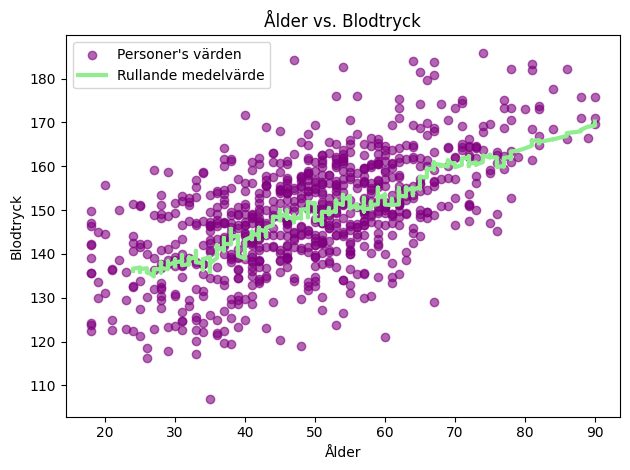

In [ ]:
# Bonus graf: En scatterplot ålder vs blodtryck, med rullande medel.
plt.figure()
plt.scatter(df['age'], df['systolic_bp'], alpha=0.6, color="purple", label="Personer's värden")
plt.title("Ålder vs. Blodtryck")
plt.xlabel("Ålder")
plt.ylabel("Blodtryck")
plt.tight_layout()

# Lägga till rullande medel
sorted = df[['age','systolic_bp']].sort_values('age') # sortera åldrarna stigande.
roll_mean = sorted['systolic_bp'].rolling(window=30).mean() # 30 första värden visar där rullande medel ska starta.
plt.plot(sorted['age'], roll_mean, linewidth=3, color="lightgreen", label="Rullande medelvärde")
plt.legend()
plt.show()

## 2. Relaterbar simulering

In [6]:
df.head(1) # en titt på df

,id,age,sex,height,weight,systolic_bp,cholesterol,smoker,disease
0,1,57,F,168.9,65.8,141.8,4.58,No,0


In [7]:
is_sick = len(df[df['disease'] == 1]) # vi får att 47st har sjukdomen.
is_sick

47

In [8]:
is_healthy = len(df) - is_sick
is_healthy # vi får att 753 är friska.

sick_vs_healthy = is_sick / len(df)
sick_vs_healthy * 100 # vi får att 5.875% är sjuka.

5.875

In [9]:
# Simulera med numpy:
np.random.seed(42)
n = 1000

# skapar 1000 nummer (0 eller 1) med sannolikhet 1-0.05875 och 0.05875, respektivt.
sim_pop = np.random.choice([0,1], size=n, p=[1-sick_vs_healthy,sick_vs_healthy]) 
print("Andel sjuka i simulerad befolkning: ",sim_pop.mean()) # vi får 0.056

# jämför simulering med actual:
print(f"Riktiga medelvärdet skiljer sig med: {round(sick_vs_healthy - float((sim_pop.mean())),6)} från simulerade medelvärdet.")
# vi får att den riktiga befolkningen har 0.28% mindre sjuka än den simulerade befolkningen.

Andel sjuka i simulerad befolkning:  0.056
Riktiga medelvärdet skiljer sig med: 0.00275 från simulerade medelvärdet.


## 3. Konfidensintervall

In [10]:
array_systolic = df['systolic_bp'].to_numpy()
array_systolic 

# Normalapproximation (z-score)
mean = array_systolic.mean() # ger 149.178625
sd = array_systolic.std(ddof=0) # använder inte ddof=1 då vi har hela population.
sd # ger ca 12.79 = standardavvikelse
n = len(array_systolic)
se = sd / np.sqrt(n) # ger ca 0.452 = standardfel (dvs osäkerhet i medelvärdet)
z = 1.96

ci_normal = (mean - z*se, mean + z*se)
np.round(ci_normal, 2) # ger ca (148.29, 150.07), 
# Om vi tar stickprov skulle 95% av intervaller som räknas ut med normalapproximation innehålla det äkta medelvärdet.

array([148.29, 150.06])

In [11]:
n = len(df) # 800 rader i df
np.random.seed(42) # reproducerbarhet (optional)

# Bootstrap
n_boot = 1000 # 1000 bootstrap resamples
boot_means = [] # lagra medelvärdena här
for i in range(n_boot): # loopa 1000 gånger
    sample = np.random.randint(0,n,n) # väljer 800st rader slumpvist med återläggning
    sample_vals = array_systolic[sample] # tar värden från slumpade rader
    boot_means.append(sample_vals.mean()) # beräkna och lagra medelvärde för varje bootstrap sample

ci_boot = (np.percentile(boot_means, [2.5, 97.5])) # 95% intervall där 2.5% ligger till höger och 2.5% till vänster.
display(ci_boot.round(2))
display(np.mean(boot_means).round(3))

array([148.31, 150.1 ])

np.float64(149.185)

In [12]:
# Jämför Normalapproximation och Bootstrap
print(f"Normalapproximerade CI - Bootstrap CI = ({round(ci_boot[0] - ci_normal[0], 3)}, {round(ci_boot[1] - ci_normal[1], 3)})")

Normalapproximerade CI - Bootstrap CI = (0.017, 0.034)


**Kommentar:**

Normalapproximation går under antagandet att blodtrycksvärdena är normalfördelade, vilket bootstrap inte behöver.

Resultaten för numeriska konfidensintervallen skiljde sig med några hundradelar (0.017, 0.034). Detta tyder på att blodtrycksvärdena i hälsodatan är normalfördelade.

**Källor:**

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition (pp. 406-411; Ch 8.5, Confidence Intervals).

## 4. Hypotesprövning

Vi ska testa om hypotesen "rökare har högre medel-blodtryck än icke-rökare".

Med den instruktionen låter ett ensidigt hypotestest närmast, fast det kan läggas om som ett tvåsidigt hypotestest, som undersöker om medel-blodtryck skiljer sig negativt eller positivt mellan grupperna.

Det tvåsidiga testet är lite mera förutsättningslöst då det inte är en antagen riktning involverad.

En sak som påverkas via valet av tvåsidigt test är $alpha$, som delas in till vänster och höger svans på normalkurvan, samtidigt som ett ensidigt hypotestest med samma $alpha$ blir mera strikt.

Mera om detta finns att läsa i Wackerly et al. (2014). 

* Vi antar att nollhypotsen $H_0$ är att det inte är någon skillnad i medelvärdena på de två grupperna rökare och icke-rökare.
* Då är alternativa hypotesen $H_a$ eller $H_1$ att det är skillnad i medelvärdena. (Har lite LateX vana)

Bootstrap förutsätter inte normalt fördelad data, så den metoden är relevant och intressant för att se statistiska resultat.

In [16]:
# Bootstrap är mer robust, medan t-test (Welch) är något enklare.

smokers_bp = df.loc[df["smoker"]=="Yes", "systolic_bp"].to_numpy() # gör array med rökare och deras blodtryck
nonsmokers_bp = df.loc[df["smoker"]=="No", "systolic_bp"].to_numpy() # samma. Vi behöver inte .dropna() för detta dataset.

diff = smokers_bp.mean() - nonsmokers_bp.mean() # tror att rökare har högre snitt, så vi subtraherar icke-rökares genomsnitt från rökares.
print("Rökare har ",round(diff,3), " högre blodtryck än icke-rökare i snitt.") # 0.472 högre blodtryck har rökare i snitt.

print("Blodtryck standardavvikelse: ", round(smokers_bp.std(),3))

Rökare har  0.472  högre blodtryck än icke-rökare i snitt.
Blodtryck standardavvikelse:  13.237


In [14]:
# Bootstrap
np.random.seed(42)
n_boot = 1000
boot_diffs = []

n_smokers = len(smokers_bp) # 213
n_nonsmokers = len(nonsmokers_bp) # 587

for i in range(n_boot):
    smokers_sample = np.random.choice(smokers_bp, n_smokers, replace=True)
    nonsmok_sample = np.random.choice(nonsmokers_bp, n_nonsmokers, replace=True)
    boot_diffs.append(smokers_sample.mean() - nonsmok_sample.mean())

ci_boot = np.percentile(boot_diffs, [2.5, 97.5])
display(ci_boot.round(3))
round(np.mean(boot_diffs),3)

# Delade upp df i grupp rökare, icke-rökare
# Gjorde 1000 par av bootstrap stickprov
# Lagrade skillnaden i medel för stickproven

array([-1.479,  2.475])

np.float64(0.474)

Tog percentiler för 95% ci av skillnad i medelvärden, och intervallet (-1.48, 2.475) innehåller 0, så hälsodata visar inte statistiskt signifikant skillnad mellan gruppernas blodtryck.

Medelvärdet på bootstrap genomsnitts skillnaderna är dock väldigt nära df's uträknade motsvarande värde.

Vi fortsätter med Welch t-test, som förutsätter ungefärlig normalfördelning men tillåter olika varianser:

In [15]:
# t-test (Welch)
from scipy import stats
t_stat, p_val = stats.ttest_ind(smokers_bp, nonsmokers_bp, equal_var=False)
round(float(t_stat),3), round(float(p_val),3)

# t värdet på ca 0.45 säger hur medelvärdena skiljer sig.
# p värdet är högre än 0.05 så vi kan inte säga att skillnaden (t) är statistiskt signifikant.

(0.45, 0.653)

In [16]:
# redan läst in pandas scipy numpy.

# Kopierar några rader från bootstrap hypotestest
smokers_bp = df.loc[df["smoker"]=="Yes", "systolic_bp"].to_numpy() # gör array med rökare och deras blodtryck
nonsmokers_bp = df.loc[df["smoker"]=="No", "systolic_bp"].to_numpy() # samma. Vi behöver inte .dropna() för detta dataset.
diff = smokers_bp.mean() - nonsmokers_bp.mean() # skillnad i genomsnittligt blodtryck mellan rökare och icke-rökare.
n_smokers = len(smokers_bp) # 213
n_nonsmokers = len(nonsmokers_bp) # 587

# Sparar medelvärden och standardavvikelser
mean_bp_smokers = np.mean(smokers_bp)
mean_bp_nonsmokers = np.mean(nonsmokers_bp)
std_bp_smokers = np.std(smokers_bp, ddof=0)
std_bp_nonsmokers = np.std(nonsmokers_bp, ddof=0)

# Definiera funktion som simulerar power
def pwr_ttest_simulator(n_simulations, alpha=0.05):
    occurences = 0 # a counter
    for _ in range(n_simulations): # loop n times 
        sample_smokers = np.random.normal(mean_bp_smokers, std_bp_smokers, n_smokers)
        sample_nonsmokers = np.random.normal(mean_bp_nonsmokers, std_bp_nonsmokers, n_nonsmokers)
        # Genererar normalfördelade stickprov runt äkta medelvärden och standardavvikelser,
        # med samma storlek som antalet rökare och icke-rökare. 

        t_stat_sim, p_val_sim = stats.ttest_ind(sample_smokers, sample_nonsmokers, equal_var=False)
        # Scipy t-test (tillåter olika varianser mellan grupperna)
        if p_val_sim < alpha:
            occurences += 1

    return occurences / n_simulations

pwr_5000_samples = pwr_ttest_simulator(n_simulations=5000)
pwr_5000_samples # ger ca 0.0772

0.0772

**Kommentar:**

Simuleringen av power med 5000 iterationer gav power 0.076, så i 7.6% av upprepningar av t-testerna uppstår meningsfull differens fastän grupperna rökare och icke-rökare har riktig skillnad. 

Om differens uppstod oftare, det vill säga om power var högre, skulle riktig skillnad upptäckas enklare. 

Att misslyckas med upptäckt av riktig skillnad är känt som $type\ II\ error$.

Medan vi fick ett CI av bootstrap, fick vi t-värde = 0.45 och p = 0.653.

Värdet på t och tidigare observerad skillnad i medelvärden är rätt lika numeriskt, men olika i matematisk metodik.

P-värdet är långt högre än 0.05, så skillnader kan enkelt komma fram slumpmässigt, och vi avfärdar därmed inte nollhypotesen $H_0$.

Givet att vi hade stort antal stickprov, en standardavvikelse $sd_{smokerBP} = 13.237$  medan värdet $t=0.45$ påvisar låg magnitud, och beaktandes att låga skillnader lätt kan framkomma med slump via ett högt p-värde, anser jag att power är låg. 

Med låg power har vi att oddsen är låga att det är någon substansiell statistisk skillnad mellan rökares- och icke-rökares blodtryck.

**Källor:** 

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 406-411; Ch 8.5, Confidence Intervals)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 537-540; Ch 10.6, Another Way to Report the Results of a Statistical Test: Attained Significance Levels, or p-Values)

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 545-549; Ch 10.8, Small-sample hypothesis testing for $\mu$ and $\mu_1 - \mu_2$)

# 5. Utökad analys av Power


Nivån på Power önskas gärna vara kring 80%, för då upptäcks skillnad mellan grupper ofta nog.

Med 5000 simuleringar fick vi power på 7.72%, så hur stor sample size behövs för att nå 80%? 

Med python-paketet statsmodels kan vi undersöka detta med en funktion TTestIndPower:

In [17]:
from statsmodels.stats.power import TTestIndPower

# Cohen's d: vi standardiserar effekt genom att beräkna sammansatt standardavvikelse
bp_mean_diff = mean_bp_smokers - mean_bp_nonsmokers
bp_sd_pooled = np.sqrt((std_bp_nonsmokers**2 + std_bp_smokers**2) / 2)
cohens_d = bp_mean_diff / bp_sd_pooled

# Parametervärden
alpha = 0.05
desired_power = 0.8

# statsmodels funktionen + beräkning av behövd stickprovsstorlek för 80% power
solver = TTestIndPower()
n_per_group = solver.solve_power(effect_size=cohens_d, alpha=alpha, power=desired_power, alternative="two-sided")

print("Cohen's d = ", round(cohens_d,4))
print("För 80% power behövs n per grupp =",np.round(n_per_group,2))

Cohen's d =  0.0365
För 80% power behövs n per grupp = 11785.42


I och med att Cohen's d värdet är mycket lågt, blir statsmodels' uträknade n_per_group värde högt, på ca 12,000.

Jämfört med vårt dataset med 800 personer totalt är stickprovsstorlek närmare 12,000 personer orimligt om sådant test skulle utföras i verkligheten.

Låt oss visualisera hur stor sample size behövs för 80% power:

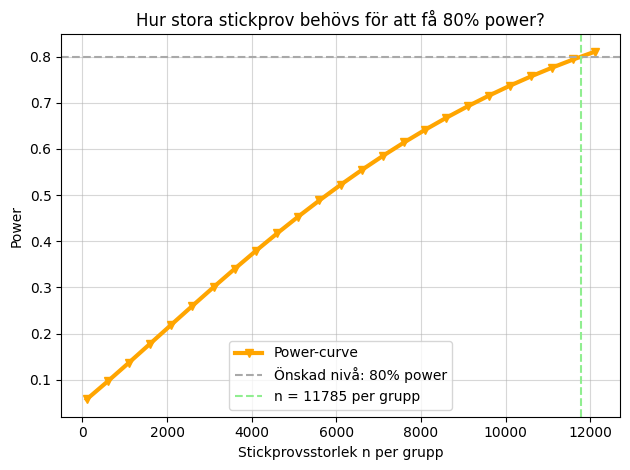

In [18]:
# (till skillnad från df dataset sample sizes som har 800 människor totalt)
n_grid = np.arange(100, 12500, 500)  # Låt x-axeln visa minst 100 till 12500 personer n_per_group, steglängd 500.
power_values = solver.power(effect_size=cohens_d, nobs1=n_grid, alpha=alpha, alternative='two-sided')
# Vi testar två-sidig skillnad mot nollhypotesen, alltså om rökare har lägre eller högre blodtryck.

fig, ax = plt.subplots()
# Plot av power-kurva, horizontal och vertical line vid önskad power och resultat för n_per_group, respektivt.
ax.plot(n_grid, power_values, color="orange", linewidth="3", marker="v", label="Power-curve")
ax.axhline(desired_power, color='darkgray', linestyle='--', label="Önskad nivå: 80% power")
ax.axvline(n_per_group, color='lightgreen', linestyle='--', label=f"n = {int(n_per_group)} per grupp")

ax.set_title("Hur stora stickprov behövs för att få 80% power?")
ax.set_xlabel("Stickprovsstorlek n per grupp")
ax.set_ylabel("Power")
plt.grid(True, alpha=0.5)
plt.legend(loc="lower center")
plt.tight_layout()

Det framstår av grafen att gällande studerade grupper med små skillnader så är mycket stora stickprovsstorlekar nödvändiga för att frekvent kunna upptäcka små skillnader mellan grupperna.

Problematiken är just detta med $type\ II\ errors$, att små samples inte räcker till för att upptäcka små skillnader.

Med bootstrap och Welch t-test uppgavs endast en liten skillnad mellan rökares och icke-rökares blodtryck á 0.45 till 0.47. Med det i åtanke är det inte särskilt problematiskt att ha observerat en låg power-nivå med så liten stickprovsstorlek som hälsodatan tillhandahöll, och att utvärdera en sådan liten skillnad via mycket stora stickprovsstorlekar är också överflödigt.

**Sammantaget** så förkastar jag *inte* nollhypotesen $H_0$. I och med liten observerad skillnad med låg upptäcktsgrad samt relativt små stickprovsstorlekar jämfört med storlekar som behövs för hög power nivå, är inte meningsfull skillnad statistiskt påvisad.

**Källor:**

https://www.statsmodels.org/stable/_modules/statsmodels/stats/power.html#TTestIndPower

Wackerly, D., Mendenhall, W., Scheaffer, R. (2014). Mathematical Statistics with Applications, 7th Edition. (pp. 545-549; Ch 10.8, Small-sample hypothesis testing for $\mu$ and $\mu_1 - \mu_2$)